## REINFORCE algorithm

In [1]:
# %reset

In [2]:
import gym
import numpy as np
import pandas as pd
import torch

from torch.distributions import Categorical, Normal
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt
from utilities import plot_learning_curve
import reinforce_classes
from reinforce_classes import two_axes_plot, PolicyNetwork, Agent

In [3]:
# Wear threshold
WEAR_THRESHOLD = 3.0 # mm
WEAR_THRESHOLD_NORMALIZED = 1.0 # normalized to the max wear threshold

gamma = 0.99
alpha = 0.01
EPISODES = 300


In [4]:
## Read data
df = pd.read_csv('Tool_Wear_VB.csv')
df = df[['time', 'VB_mm', 'ACTION_CODE']]

# Normalizing entire df with min-max scaling
WEAR_MIN = df['VB_mm'].min() 
WEAR_MAX = df['VB_mm'].max()
WEAR_THRESHOLD_NORMALIZED = (WEAR_THRESHOLD-WEAR_MIN)/(WEAR_MAX-WEAR_MIN)

df_normalized = (df-df.min())/(df.max()-df.min())
print(f'Tool wear data imported ({len(df.index)} records). WEAR_THRESHOLD_NORMALIZED: {WEAR_THRESHOLD_NORMALIZED:4.3f}')

# ## Visualize the data
# n_records = len(df.index)
# x = df['time'].values.tolist()
# y1 = df['VB_mm'].values.tolist()
# y2 = df['ACTION_CODE'].values.tolist()

# two_axes_plot(x, y1, y2, title='Tool Wear (mm) data', \
#               x_label='Time', y1_label='Tool Wear (mm)', y2_label='Action code (1=Replace)', \
#               xticks=10,threshold=WEAR_THRESHOLD)

Tool wear data imported (121 records). WEAR_THRESHOLD_NORMALIZED: 0.168


### Environment class - Milling Tool Wear "environment"
- Simple actions: Replace / do-not-replace
- Reward for every step of lengthened life
- Reward for every step where wear < Threshold
- Penalty (cost) for replacement
- Termination condition:
    - Wear > Threshold
    - End of Wear data-frame
    - Episode length >1000


In [5]:
#-----------------------------------------------------------------------------------------------------------------
# Milling Tool wear environment 
# Author: Rajesh Siraskar
# Date: 28-Apr-2023
# V 2.0: Open AI Gym compliant. Fix threshold normalization bug. Potential reward function errors
# V 3.0 Modify reward function and simpify to basics
#-----------------------------------------------------------------------------------------------------------------

import gym
from gym import spaces
import pandas as pd
import numpy as np
import gc

#MillingTool_V4
class MTE(gym.Env):
    """Custom Milling Tool Wear Environment that follows the Open AI gym interface."""

    metadata = {"render.modes": ["human"]}
    
    def __init__(self, df, wear_threshold):        

        # Machine data frame properties    
        self.df = df
        self.df_length = len(self.df.index)
        self.df_index = 0
        
        # Milling operation and tool parameters 
        self.wear_threshold = wear_threshold
        self.episode_length = 0
        self.EL = 0
        self.reward = 0.0
        
        # Statistics
        self.ep_total_reward = 0
        self.ep_tool_replaced = 0
        self.ep_length_history = []
        self.ep_total_reward_history = []
        self.ep_tool_replaced_history = []
        
        ## Gym interface Obsercation and Action spaces
        # All features are normalized [0, 1]
        self.min_feature = 0.0
        self.max_feature = 1.0
        
        # Define state and action limits        
        self.low_state = np.array([self.min_feature, self.min_feature], dtype=np.float32)
        self.high_state = np.array([self.max_feature, self.max_feature], dtype=np.float32)
        
        # Observation and action spaces
        self.action_space = spaces.Discrete(2)
        self.observation_space = spaces.Box(low=self.low_state, high=self.high_state, dtype=np.float32)
             
    def step(self, action):
        """
        Args: action. Discrete - 1=Replace tool, 0=Continue milling operation
        Returns: next_state, reward, terminated, truncated , info
        """
        # Termination condition
        if self.EL > 1000:
            terminated = True
            info = {'termination':'Operations crossed.'}
        else:
            self.EL = self.EL + 1
            terminated = False
            info = {'action':'Continue'} 
        
            # Get current observation frome environment
            self.state = self._get_observation(self.df_index)
            time_step = self.state[0]
            wear = self.state[1]

            ## Reward function:
            # +ve Rewards:
            #  1. Each time-step survived: +4.0 (milling operation lengthened)
            #  2. Tool wear < Threshold: +1.0
            # -ve Penalties:
            #  3. Above threshold: -2.0
            #  4. Tool replaced: -10.0
            # Termination:
            #  1. Time-steps (operations) > 1000
            #  2. Data-frame end

            reward = 0.0
            # reward += 4.0 # 1. Each time-step survived: +4.0

            if wear < self.wear_threshold:
                reward += self.df_index
            else:
                # Threshold breached
                reward += -self.df_index # farther away from threshold => more penalty

            # Based on the action = 1 replace the tool or if 0, continue with normal operation
            if action:
                reward += -100.0
                # We replace the tool - so roll back tool life. -1 so that the increment in df_index will reset it to 0
                self.df_index = -1
                self.ep_tool_replaced += 1
                info = {'action':'Tool replaced'}

            # Increment reward for the episode based on final evaluation of reward of this step
            self.reward += float(reward/1e3)
            self.ep_total_reward += self.reward

            # print(f'** {self.df_index:>3d} | Ep.Len.: {self.episode_length:>3d} | Reward: {self.reward:>10.4f} | Wear: {wear:>5.4f} | {info}')
            # print(f'** {self.df_index:>3d} | Ep.Len.: {self.EL:>3d} -- {info}')

            # Post process of step: Get next observation, fill history arrays
            self.episode_length += 1
            
            if self.df_index > (self.df_length-2):
                self.df_index = -1
                # print(f' ^^Data over^^ {self.df_index:>3d} | Ep.Len.: {self.EL:>3d} -- {info}')
                info = {'data_index':'Data over'}

            # We can now read the next state, for agent's policy to predict the "Action"
            self.df_index += 1
            state_ = self._get_observation(self.df_index)
        
        return state_, self.reward, terminated, info

    def _get_observation(self, index):
        next_state = np.array([
            self.df['time'][index],
            self.df['VB_mm'][index]
        ], dtype=np.float32)
                
        return next_state

    def reset(self):
        #print('\n', 80*'-')
        self.ep_total_reward_history.append(self.ep_total_reward)
        self.ep_length_history.append(self.episode_length)
        self.ep_tool_replaced_history.append(self.ep_tool_replaced)
        
        self.EL = 0
        
        self.ep_total_reward = 0
        self.ep_tool_replaced = 0
        self.episode_length = 0
    
        # self.df_index = 0
        self.reward = 0.0
        self.state = self._get_observation(self.df_index)
        
        terminated = False
         
        return np.array(self.state, dtype=np.float32)
    
    def render(self, mode='human', close=False):
        print(f'-- Index: {self.df_index:4d}: Reward: {self.reward:>12.3f}')
        
    def close(self):
        del [self.df]
        gc.collect()
        print('** -- Envoronment closed. Data-frame memory released. Garbage collector invoked successfully -- **')


In [7]:
### Main loop
EPISODES = 300
rewards_history = []
loss_history = []

env = MTE(df_normalized, WEAR_THRESHOLD_NORMALIZED)
input_dim = env.observation_space.shape[0]
output_dim = env.action_space.n

agent = Agent(input_dim, output_dim, alpha, gamma)

for episode in range(EPISODES):
    state = env.reset()
    
    # Sample a trajectory. 
    for t in range(1000): # Max. time-steps for CartPole is 200
        action = agent.act(state)
        state, reward, done, _ = env.step(action)
        agent.rewards.append(reward)
        #env.render()
        if done:
            break
        
    loss = agent.learn() # train per episode
    total_reward = sum(agent.rewards)
    
    rewards_history.append(total_reward)
    loss_history.append(loss.item()) # Extract values from list of torch items for plotting
    
    agent.onpolicy_reset()

    if (episode%50 ==0):
        print(f'[{episode:04d}] Loss: {loss:>.3Ef} | Reward: {total_reward:>8.2f} | Ep.length: {env.episode_length:04d}')

# env.close()

[0000] Loss: -1793915.25 | Reward: -26536.88 | Ep.length: 1000
[0050] Loss: -521735.75 | Reward: -10152.81 | Ep.length: 1000
[0100] Loss:   59209.22 | Reward:  2306.82 | Ep.length: 1000
[0150] Loss:   93669.49 | Reward:  5034.32 | Ep.length: 1000
[0200] Loss:  132238.38 | Reward:  9407.45 | Ep.length: 1000
[0250] Loss:   90914.10 | Reward: 10739.89 | Ep.length: 1000


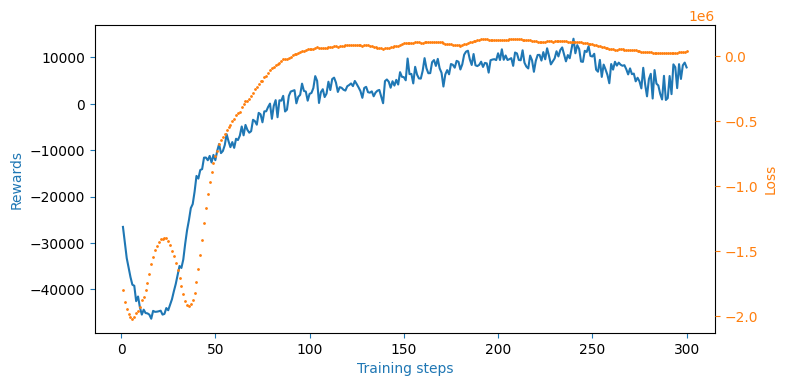

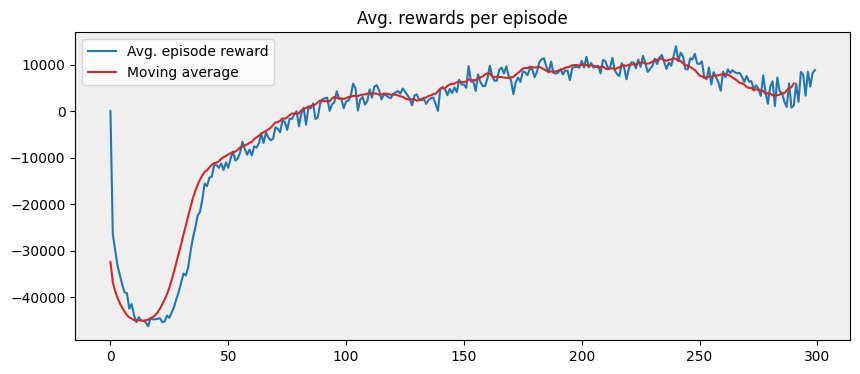

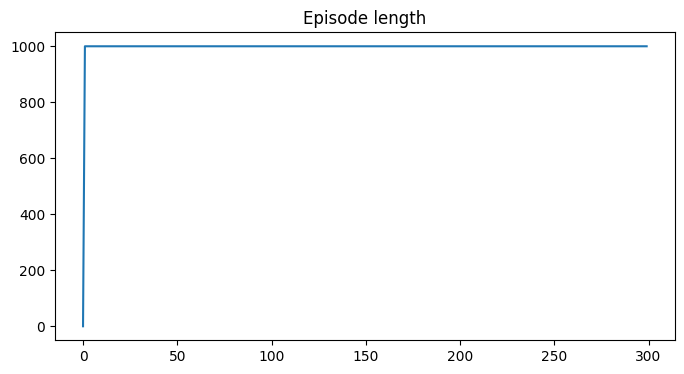

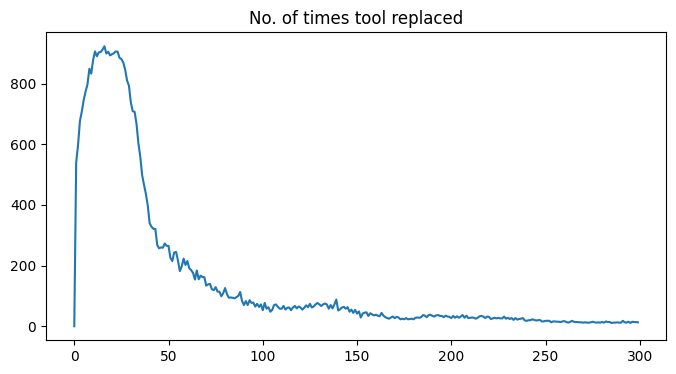

In [9]:
filename='Tool_Wear_V1_Rewards.png'
x = [i+1 for i in range(EPISODES)]
plot_learning_curve(x, rewards_history=rewards_history, loss_history=loss_history, 
                    moving_avg_n=10, filename='Tool_Wear_V1_Rewards.png') 

plt.rcParams['figure.figsize'] = (8, 4)

ax = plt.axes()
ax.set_facecolor('#EFEFEF')

window_size = 10
# Convert error array to pandas series
ma_reward = pd.Series(env.ep_total_reward_history)
windows = ma_reward.rolling(window_size)
moving_avg = windows.mean()
moving_avg_lst = moving_avg.tolist()
# Remove null entries from the list
moving_avg_lst = moving_avg_lst[window_size - 1:]

filename='Tool_Wear_V1_Avg_rewards_per_episode.png'
plt.plot(env.ep_total_reward_history,  color='tab:blue')
plt.plot(moving_avg_lst, color='tab:red')
plt.legend(['Avg. episode reward', 'Moving average'])
plt.title('Avg. rewards per episode')
plt.savefig(filename)
plt.show()

filename='Tool_Wear_V1_Tool_Replacements.png'
plt.plot(env.ep_length_history)
plt.title('Episode length')
plt.show()
plt.plot(env.ep_tool_replaced_history)
plt.title('No. of times tool replaced')
plt.savefig(filename)
plt.show()